In [1]:
import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from tqdm import trange
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Sample implementation of FFNN 

In [15]:
import random
import numpy as np

class DeepFFNN(object):
    """
    Author: Hanbaek Lyu
    Genearal Deep Feedforward Neural Network implementation 
    Input data type: training_data = [pattern1, pattern2, ..., pattern n]
    Activation: tanh for hidden layer and sigmoid for output layer 
    
    pattern i = [np.array (input), np.array (output)]
    
    TODO: Currently uses square loss. Should be easy to implement other loss functions. 
    """
    def __init__(self, 
                 hidden_layer_sizes,  # input and output layer sizes read off from training data
                 training_data,  # list of patterns [np.array (input), np.array (output)]
                 activation_list=None): # desired list of activation functions in each layer. 
       
        # initialize training data and layer info
        self.training_data = training_data
        self.activation_list = activation_list
        self.list_layer_sizes = [len(self.training_data[0][0]) + 1] + hidden_layer_sizes + [len(self.training_data[0][1])]        
        # add hidden unit in the input layer. No hidden units for the hidden layers. 
        self.n_layers = len(self.list_layer_sizes)-1
        
        self.initialize()
        
    def initialize(self):
        
        # list of activation functions
        if self.activation_list is None:
            activation_list = ['tanh' for i in np.arange(len(self.list_layer_sizes))]
            activation_list[0] = 'identity'  # dummy activation for the input layer
            activation_list[-1] = 'sigmoid'
            self.activation_list = activation_list

        # default activation of nodes
        node_states = []
        for i in np.arange(len(self.list_layer_sizes)):
            node_states.append(np.zeros(shape=[self.list_layer_sizes[i], ]))
        self.node_states = node_states
        
        # initial weight matrices 
        # use scheme from 'efficient backprop to initialize weights'
        weight_matrices = []
        for i in np.arange(self.n_layers):
            weight_range = 1/(self.list_layer_sizes[i]**(0.5))
            U = np.random.normal(loc = 0, scale = weight_range, size = (self.list_layer_sizes[i], self.list_layer_sizes[i+1]))
            weight_matrices.append(U)
            print('weight_matrix.shape', U.shape)
        self.weight_matrices = weight_matrices
           
        # create arrays of 0's to store previous gradients for momentum term in SGD update 
        prev_grad_list = []
        for i in np.arange(self.n_layers):
            V = np.zeros((self.list_layer_sizes[i], self.list_layer_sizes[i+1]))
            prev_grad_list.append(V)
        self.prev_grad_list = prev_grad_list

    def forwardPropagate(self, inputs):
        # Forward propagate the input using the current weights and update node states 
        self.node_states[0][:-1] = inputs # avoid last coordinate for hidden unit 
        for i in np.arange(self.n_layers):    
            X_new = self.node_states[i].T @ self.weight_matrices[i]
            X_new = activation(X_new, type=self.activation_list[i+1])
            self.node_states[i+1] = X_new
        
        return self.node_states[-1]

    def backPropagate(self, targets):
        """
        Backpropagate errors from the output to the input layer 
        Return gradients for the weight matrices
        """
    
        error_list = self.node_states.copy()
        # error at the output layer to be backpropagated 
        error = -(np.asarray(targets) - np.asarray(self.node_states[-1]))
        for L in range(self.n_layers, 0, -1): # layer index to be backpropagated 
            # print('L', L)
            if L < self.n_layers: # Not backpropagating from the output layer
                error = self.weight_matrices[L] @ error_list[L+1].reshape(-1,1)
                error = error[:,0] 
            error_list[L] = delta_activation(self.node_states[L], type=self.activation_list[L]) * error
            
        # Compute the gradients
        grad_list = self.weight_matrices.copy()
        for i in np.arange(self.n_layers):
            grad_list[i] = self.node_states[i].reshape(-1,1) @ error_list[i+1].reshape(1,-1) 
        
        return grad_list


    def train(self, iterations=100, learning_rate=0.5, momentum=0.5, rate_decay=0.01, verbose=True):
        # N: learning rate
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.rate_decay = rate_decay
        error = 10
        i=0
        while (i<iterations) and (error>0.001):
            error = 0.0
            random.shuffle(self.training_data)
            for p in self.training_data:
                inputs = p[0]
                targets = p[1]
                self.forwardPropagate(inputs)
                grad_list = self.backPropagate(targets)
                
                for L in np.arange(self.n_layers):
                    # update the L th weight matrix connecting L th and (L+1)st layers 
                    grad = grad_list[L]
                    prev_grad = self.prev_grad_list[L]
                    self.weight_matrices[L] -= self.learning_rate * grad + self.momentum * prev_grad
                    self.prev_grad_list[L] = grad # store current gradient 
        
                error += (0.5) * np.linalg.norm(np.asarray(targets) - self.node_states[-1])**2
            
            with open('error.txt', 'a') as errorfile:
                errorfile.write(str(error) + '\n')
                errorfile.close()
                
            if (i % 5 == 0) and verbose:
                print('iteration %i, error %-.5f' % (i, error))
            # learning rate decay
            self.learning_rate = 1/(np.log(i+2) * (i+50)**(0.5))
            # self.learning_rate = self.learning_rate * (self.learning_rate / (self.learning_rate + (self.learning_rate * self.rate_decay)))
            
            i += 1  
        
    
    def predict(self, X, normalize = False):
        X = np.asarray(X).T
        x = np.vstack((np.asarray(X), np.ones(X.shape[1]))) # add 1 for hidden units in the input layer
        print('X.shape', X.shape)
    
        for i in np.arange(self.n_layers):    
            x = x.T @ self.weight_matrices[i]
            x = activation(x.T, type=self.activation_list[i+1])
            
        print('y_hat.shape', x.shape)
        return x
    
### Helper functions     
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# derivative of sigmoid
def dsigmoid(y):
    return y * (1.0 - y)

# using tanh over logistic sigmoid is recommended   

def tanh(x):
    return (1-np.exp(-2*x))/(1+np.exp(-2*x))
    # return np.tanh(x)
    
# derivative for tanh sigmoid
def dtanh(y):
    return 1 - y*y


### Helper functions

def loss_function(y, y_hat, type='cross-entropy'):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    if type == 'cross_entropy':
        return cross_entropy(y=y, y_hat=y_hat)
    elif type == 'square':
        return (1/2) * (y_hat - y).T @ (y_hat - y)
    elif type == 'softmax-cross-entropy':
        return cross_entropy(y=y, y_hat=softmax(y_hat))
   

def delta_loss_function(y, y_hat, type='cross-entropy'):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    # return delta_cross_entropy(y=y, y_hat=y_hat/np.sum(y_hat))
    
    if type == 'cross-entropy':
        return delta_cross_entropy(y=y, y_hat=y_hat)
    elif type == 'square':
        return y_hat - y
    elif type == 'softmax-cross-entropy':
        return softmax(y_hat) - y

        
def activation(x, type='sigmoid'):
    if type == 'sigmoid':
        return 1/(1+np.exp(-x))
    elif type == 'ReLU':
        return np.maximum(0,x)
    elif type == 'tanh':
        return tanh(x)
    elif type == 'identity':
        return x
    
def delta_activation(y, type='sigmoid'):
    # derivate of activation function
    if type == 'sigmoid':
        return y*(1-y)
    elif type == 'ReLU':
        return int((y>0))
    elif type == 'tanh':
        return 1-y**2
    elif type == 'identity':
        return 1
        
def sigmoid(x):
    return 1/(1+np.exp(-x))

def ReLU(x):
    return np.maximum(0,x)


def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

def cross_entropy(y, y_hat):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    return -(y.T @ np.log(y_hat))[0][0]

def delta_cross_entropy(y, y_hat):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    y_hat /= np.max(y_hat)
    z = y.copy()
    for i in np.arange(y.shape[0]):
        a = y.argmax(axis=0)[0]
        z[i,0] = -1/y_hat[a, 0]
    return z

## Classifying MNIST images using FFNN

In [3]:
def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])
        
    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [4]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

In [5]:
def sample_multiclass_MNIST(list_digits=['0','1', '2'], full_MNIST=None):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(X01[i,:])
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test


In [6]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False, verbose=True):
    
    # y_test = binary label 
    # P_pred = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)
    
    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre
    
    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})
    results_dict.update({'Confusion_mx': mcm})
    
    
    if verbose:
        for key in [key for key in results_dict.keys()]:
            if key not in ['Y_test', 'Y_pred', 'Confusion_mx']:
                print('% s ===> %.3f' % (key, results_dict.get(key)))
        print('Confusion matrix  ===> \n', mcm)
            
    return results_dict

In [7]:
def multiclass_accuracy_metrics(Y_test, P_pred, class_labels=None, use_opt_threshold=False):
    # y_test = multiclass one-hot encoding  labels [samples x labels]
    # Q = predicted probability for y_test
    # compuate various classification accuracy metrics
    results_dict = {}
    y_test = []
    y_pred = []
    for i in np.arange(Y_test.shape[0]):
        for j in np.arange(Y_test.shape[1]):
            if Y_test[i,j] == 1:
                y_test.append(j)
            if P_pred[i,j] == np.max(P_pred[i,:]):
                # print('!!!', np.where(P_pred[i,:]==np.max(P_pred[i,:])))
                y_pred.append(j)
            
    confusion_mx = metrics.confusion_matrix(y_test, y_pred)
    results_dict.update({'confusion_mx':confusion_mx})
    results_dict.update({'Accuracy':np.trace(confusion_mx)/np.sum(np.sum(confusion_mx))})
    print('!!! confusion_mx', confusion_mx)
    print('!!! Accuracy', results_dict.get('Accuracy'))
    
    
    return results_dict

In [8]:
def random_padding(img, thickness=1):
    # img = a x b image 
    [a,b] = img.shape
    Y = np.zeros(shape=[a+thickness, b+thickness])
    r_loc = np.random.choice(np.arange(thickness+1))
    c_loc = np.random.choice(np.arange(thickness+1))
    Y[r_loc:r_loc+a, c_loc:c_loc+b] = img
    return Y

In [9]:
def sample_multiclass_MNIST_padding(list_digits=['0','1', '2'], full_MNIST=[X,y], padding_thickness=10):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    # pad each 28 x 28 image with zeros so that it has now "padding_thickness" more rows and columns
    # The original image is superimposed at a uniformly chosen location 
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        img_padded = random_padding(X01[i,:].reshape(28,28), thickness=padding_thickness)
        img_padded_vec = img_padded.reshape(1,-1)
        if U<0.8:
            X_train.append(img_padded_vec[0,:].copy())
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(img_padded_vec[0,:].copy())
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test

100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 43824.58it/s]


weight_matrix.shape (785, 3)
weight_matrix.shape (3, 5)
iteration 0, error 99.70890
iteration 5, error 67.75389
iteration 10, error 66.92702
iteration 15, error 66.55682
iteration 20, error 65.36895
iteration 25, error 64.69073
iteration 30, error 64.29553
iteration 35, error 64.01701
iteration 40, error 63.87916
iteration 45, error 63.77858
iteration 50, error 63.66277
iteration 55, error 63.51501
iteration 60, error 63.14259
iteration 65, error 62.94980
iteration 70, error 62.78697
iteration 75, error 62.54362
iteration 80, error 62.26797
iteration 85, error 61.82920
iteration 90, error 61.38098
iteration 95, error 60.89526

X.shape (784, 300)
y_hat.shape (5, 300)
X.shape (784, 7059)
y_hat.shape (5, 7059)
!!! confusion_mx [[62  0  2  0  0]
 [ 0 58  1  0  0]
 [ 0  0 66  0  0]
 [ 0  0 57  0  0]
 [42  0  0  0 12]]
!!! Accuracy 0.66
!!! confusion_mx [[1258    0  115    0    0]
 [   7 1497   76    0    2]
 [  63   27 1212    0    0]
 [  45   14 1329    0    5]
 [1172   48   68    0  121]]

100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 44028.20it/s]


weight_matrix.shape (1226, 3)
weight_matrix.shape (3, 5)
iteration 0, error 122.95223
iteration 5, error 91.10714
iteration 10, error 80.08625
iteration 15, error 74.60046
iteration 20, error 71.20457
iteration 25, error 68.98602
iteration 30, error 68.02762
iteration 35, error 66.64327
iteration 40, error 65.28131
iteration 45, error 64.86157
iteration 50, error 64.38392
iteration 55, error 63.84810
iteration 60, error 62.58740
iteration 65, error 62.30095
iteration 70, error 62.19632
iteration 75, error 62.06912
iteration 80, error 61.97013
iteration 85, error 61.88036
iteration 90, error 61.79583
iteration 95, error 61.72932

X.shape (1225, 300)
y_hat.shape (5, 300)
X.shape (1225, 7132)
y_hat.shape (5, 7132)
!!! confusion_mx [[ 0  0 52  0  0]
 [ 0 66  5  0  0]
 [ 0  0 62  0  0]
 [ 0  0  6 60  0]
 [ 0  0 49  0  0]]
!!! Accuracy 0.6266666666666667
!!! confusion_mx [[   0   43 1146  206    0]
 [   0 1193  175  225    0]
 [   0  142  920  304    0]
 [   0  154  424  835    0]
 [   0  23

100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 37976.56it/s]


weight_matrix.shape (1682, 3)
weight_matrix.shape (3, 5)
iteration 0, error 123.92924
iteration 5, error 106.06891
iteration 10, error 100.94654
iteration 15, error 97.61489
iteration 20, error 94.82289
iteration 25, error 91.67029
iteration 30, error 89.89118
iteration 35, error 87.61274
iteration 40, error 84.41388
iteration 45, error 81.54761
iteration 50, error 79.40091
iteration 55, error 77.49178
iteration 60, error 75.13940
iteration 65, error 73.97516
iteration 70, error 73.36089
iteration 75, error 72.79281
iteration 80, error 72.17603
iteration 85, error 71.55657
iteration 90, error 70.56421
iteration 95, error 69.69377

X.shape (1681, 300)
y_hat.shape (5, 300)
X.shape (1681, 7067)
y_hat.shape (5, 7067)
!!! confusion_mx [[65  0  0  0  0]
 [ 9 53  0  0  0]
 [61  0  0  0  0]
 [ 7  0  0 45  3]
 [11  0  0  0 46]]
!!! Accuracy 0.6966666666666667
!!! confusion_mx [[992 138   0 132 107]
 [399 732   3 294 133]
 [782 205   0 269 135]
 [655 272   2 407 109]
 [520 359   1 249 172]]
!!! 

100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:01<00:00, 32885.76it/s]


weight_matrix.shape (2305, 3)
weight_matrix.shape (3, 5)
iteration 0, error 125.17220
iteration 5, error 109.48061
iteration 10, error 103.14945
iteration 15, error 101.31775
iteration 20, error 99.31699
iteration 25, error 97.77561
iteration 30, error 96.95895
iteration 35, error 95.75916
iteration 40, error 95.28070
iteration 45, error 94.21861
iteration 50, error 92.16257
iteration 55, error 91.24852
iteration 60, error 90.19447
iteration 65, error 89.81452
iteration 70, error 89.50846
iteration 75, error 88.54891
iteration 80, error 87.62010
iteration 85, error 86.82145
iteration 90, error 86.35113
iteration 95, error 86.15023

X.shape (2304, 300)
y_hat.shape (5, 300)
X.shape (2304, 7039)
y_hat.shape (5, 7039)
!!! confusion_mx [[ 0  0  0 63  0]
 [ 0 49  0 11  0]
 [ 0  0  0 55  0]
 [ 0  0  0 69  0]
 [ 0  0  0 27 26]]
!!! Accuracy 0.48
!!! confusion_mx [[   0  189    0 1074   84]
 [   0  778    0  590  205]
 [   0  231    0  998  103]
 [   0  235    0 1062   74]
 [   0  293    0  882

100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 47757.34it/s]


weight_matrix.shape (785, 3)
weight_matrix.shape (3, 5)
iteration 0, error 154.40528
iteration 5, error 104.06920
iteration 10, error 101.46812
iteration 15, error 100.96677
iteration 20, error 100.61635
iteration 25, error 100.60391
iteration 30, error 100.41371
iteration 35, error 100.34333
iteration 40, error 100.09484
iteration 45, error 100.19680
iteration 50, error 100.12853
iteration 55, error 99.62177
iteration 60, error 99.48967
iteration 65, error 99.37315
iteration 70, error 99.36841
iteration 75, error 99.35990
iteration 80, error 99.31436
iteration 85, error 99.28169
iteration 90, error 99.24650
iteration 95, error 99.19764

X.shape (784, 500)
y_hat.shape (5, 500)
X.shape (784, 7148)
y_hat.shape (5, 7148)
!!! confusion_mx [[ 86   0   0   0   1]
 [  0 122   0   1   2]
 [  0   0   0   0  92]
 [  0   0   0   0  97]
 [  0   0   0   0  99]]
!!! Accuracy 0.614
!!! confusion_mx [[1351    0    0   10   37]
 [   2 1443    0    8   51]
 [  52   10    0   23 1308]
 [  35   16    0   

100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 41131.91it/s]


weight_matrix.shape (1226, 3)
weight_matrix.shape (3, 5)
iteration 0, error 193.13562
iteration 5, error 157.10682
iteration 10, error 143.15722
iteration 15, error 132.10610
iteration 20, error 126.93314
iteration 25, error 123.30505
iteration 30, error 120.30497
iteration 35, error 117.22504
iteration 40, error 115.64803
iteration 45, error 114.57591
iteration 50, error 113.76847
iteration 55, error 113.36702
iteration 60, error 113.02653
iteration 65, error 112.67940
iteration 70, error 112.40488
iteration 75, error 112.12240
iteration 80, error 111.84254
iteration 85, error 111.58808
iteration 90, error 111.36444
iteration 95, error 111.17037

X.shape (1225, 500)
y_hat.shape (5, 500)
X.shape (1225, 7109)
y_hat.shape (5, 7109)
!!! confusion_mx [[ 92   0   0  10   3]
 [  1  98   0  11   0]
 [  1   0   1  79   5]
 [  1   0   0 110   0]
 [  1   0   0  62  25]]
!!! Accuracy 0.652
!!! confusion_mx [[ 926   47    0  390   14]
 [  92 1172    2  254   39]
 [ 211  148    1  983   34]
 [ 156 

100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 38811.38it/s]


weight_matrix.shape (1682, 3)
weight_matrix.shape (3, 5)
iteration 0, error 203.95136
iteration 5, error 188.16816
iteration 10, error 182.82718
iteration 15, error 176.69184
iteration 20, error 175.69758
iteration 25, error 175.22158
iteration 30, error 174.74959
iteration 35, error 174.01098
iteration 40, error 173.63048
iteration 45, error 173.12064
iteration 50, error 172.83487
iteration 55, error 172.66781
iteration 60, error 172.48324
iteration 65, error 172.28650
iteration 70, error 172.10529
iteration 75, error 172.00078
iteration 80, error 171.79356
iteration 85, error 171.59328
iteration 90, error 171.51261
iteration 95, error 171.46568

X.shape (1681, 500)
y_hat.shape (5, 500)
X.shape (1681, 7107)
y_hat.shape (5, 7107)
!!! confusion_mx [[  0   0  78   0   0]
 [  0  66  53   0   0]
 [  0   0 116   0   0]
 [  0   0 106   0   0]
 [  0   1  80   0   0]]
!!! Accuracy 0.364
!!! confusion_mx [[   0   35 1341    0    0]
 [   0  714  828    0    0]
 [   0  120 1270    0    0]
 [   0 

100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:01<00:00, 32906.75it/s]


weight_matrix.shape (2305, 3)
weight_matrix.shape (3, 5)
iteration 0, error 201.15464
iteration 5, error 176.54011
iteration 10, error 169.65183
iteration 15, error 168.28756
iteration 20, error 167.07783
iteration 25, error 166.36520
iteration 30, error 165.86229
iteration 35, error 165.10712
iteration 40, error 163.84273
iteration 45, error 162.28359
iteration 50, error 160.52537
iteration 55, error 159.16309
iteration 60, error 156.42991
iteration 65, error 154.40277
iteration 70, error 152.98512
iteration 75, error 151.08275
iteration 80, error 150.33007
iteration 85, error 149.08479
iteration 90, error 148.16442
iteration 95, error 146.96398

X.shape (2304, 500)
y_hat.shape (5, 500)
X.shape (2304, 7092)
y_hat.shape (5, 7092)
!!! confusion_mx [[11  0  4 78  0]
 [ 0 83  0 25  0]
 [ 0  0 51 60  0]
 [ 1  0 10 87  0]
 [ 9  1  1 79  0]]
!!! Accuracy 0.464
!!! confusion_mx [[  17   79  179 1055    0]
 [  31  817  251  520    1]
 [   5  109  346  961    0]
 [   8  146  225  964    0]
 [  

100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 42655.38it/s]


weight_matrix.shape (785, 3)
weight_matrix.shape (3, 5)
iteration 0, error 274.57643
iteration 5, error 213.32250
iteration 10, error 211.08504
iteration 15, error 208.93521
iteration 20, error 207.78056
iteration 25, error 207.77272
iteration 30, error 207.65593
iteration 35, error 207.40479
iteration 40, error 207.53817
iteration 45, error 207.38835
iteration 50, error 207.32036
iteration 55, error 206.65061
iteration 60, error 206.47705
iteration 65, error 206.15239
iteration 70, error 205.26885
iteration 75, error 204.92103
iteration 80, error 204.96530
iteration 85, error 204.88805
iteration 90, error 205.12791
iteration 95, error 204.99222

X.shape (784, 1000)
y_hat.shape (5, 1000)
X.shape (784, 7095)
y_hat.shape (5, 7095)
!!! confusion_mx [[177   0   0   4   0]
 [  0 224   0   5   0]
 [  0   2   0 184   0]
 [  0   0   0 214   0]
 [  0   1   0 189   0]]
!!! Accuracy 0.615
!!! confusion_mx [[1316    0    0   64    0]
 [   1 1518    0   59    0]
 [  34   37    0 1303    0]
 [  10  

100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 38514.91it/s]


weight_matrix.shape (1226, 3)
weight_matrix.shape (3, 5)
iteration 0, error 377.88865
iteration 5, error 325.49897
iteration 10, error 277.98894
iteration 15, error 250.20660
iteration 20, error 241.46121
iteration 25, error 238.41596
iteration 30, error 234.15361
iteration 35, error 232.41975
iteration 40, error 230.95086
iteration 45, error 229.68114
iteration 50, error 228.58233
iteration 55, error 226.79873
iteration 60, error 226.25702
iteration 65, error 225.87232
iteration 70, error 225.68018
iteration 75, error 225.41706
iteration 80, error 224.99451
iteration 85, error 224.56799
iteration 90, error 224.33764
iteration 95, error 224.16183

X.shape (1225, 1000)
y_hat.shape (5, 1000)
X.shape (1225, 7092)
y_hat.shape (5, 7092)
!!! confusion_mx [[192   0   1   1   1]
 [  3 188  24   0   7]
 [141   0  44   8   3]
 [156   3  12  25   0]
 [  2   2   0   1 186]]
!!! Accuracy 0.635
!!! confusion_mx [[1223   30   57   32   37]
 [ 101 1133  158   59   99]
 [ 985   49   98   59  184]
 [107

100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 40166.37it/s]


weight_matrix.shape (1682, 3)
weight_matrix.shape (3, 5)
iteration 0, error 409.19957
iteration 5, error 329.45177
iteration 10, error 300.60036
iteration 15, error 287.89816
iteration 20, error 274.88996
iteration 25, error 269.84893
iteration 30, error 264.06716
iteration 35, error 260.02831
iteration 40, error 256.84284
iteration 45, error 254.30396
iteration 50, error 251.06537
iteration 55, error 248.96256
iteration 60, error 245.68830
iteration 65, error 244.34694
iteration 70, error 242.51908
iteration 75, error 241.73670
iteration 80, error 241.34133
iteration 85, error 240.72057
iteration 90, error 240.25252
iteration 95, error 239.88111

X.shape (1681, 1000)
y_hat.shape (5, 1000)
X.shape (1681, 7104)
y_hat.shape (5, 7104)
!!! confusion_mx [[209   0   0   0   0]
 [  8 183  26   0   0]
 [116   0  66   4   2]
 [166   1   0  32   0]
 [ 15  13   0   5 154]]
!!! Accuracy 0.644
!!! confusion_mx [[1116   72   82   25   87]
 [ 208  945  153   84  198]
 [ 866  144  116   39  216]
 [ 89

100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:01<00:00, 27909.27it/s]


weight_matrix.shape (2305, 3)
weight_matrix.shape (3, 5)
iteration 0, error 409.82962
iteration 5, error 368.88527
iteration 10, error 361.27670
iteration 15, error 352.22415
iteration 20, error 348.94551
iteration 25, error 345.16735
iteration 30, error 343.34402
iteration 35, error 341.97216
iteration 40, error 341.16871
iteration 45, error 340.37086
iteration 50, error 339.97629
iteration 55, error 339.55451
iteration 60, error 339.27632
iteration 65, error 338.99580
iteration 70, error 338.49613
iteration 75, error 337.76856
iteration 80, error 336.66626
iteration 85, error 335.35626
iteration 90, error 334.09299
iteration 95, error 332.55029

X.shape (2304, 1000)
y_hat.shape (5, 1000)
X.shape (2304, 7152)
y_hat.shape (5, 7152)
!!! confusion_mx [[  3   0   0 186   0]
 [  0 157   0  72   0]
 [  2   0   0 179   0]
 [  0   1   0 202   1]
 [  9   4   0 181   3]]
!!! Accuracy 0.365
!!! confusion_mx [[  12   98    0 1239    3]
 [  12  750    0  764   39]
 [   7  115    0 1243   10]
 [   

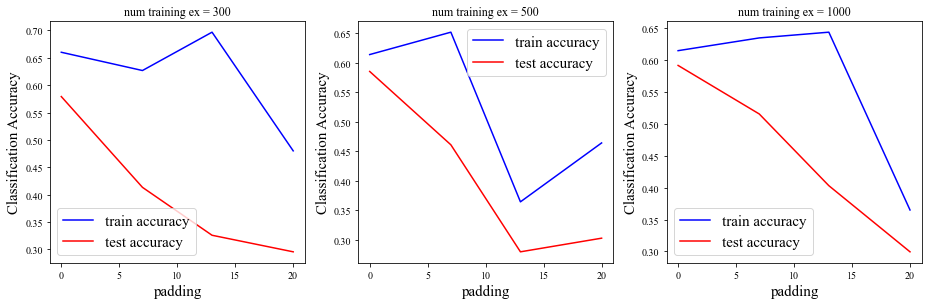

In [18]:
# compute comparative multiclass classification metrics on test data
padding_list = [0, 7, 13, 20]
list_digits=['0','1','2','3','4']
train_size_list = [300, 500, 1000]

# make plot
ncols = len(train_size_list)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=[13,5])

for t in np.arange(len(train_size_list)):
    accuracy_list_test = []
    accuracy_list_train = []
    
    train_size = train_size_list[t]
    
    for thickness in padding_list:
        X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, 
                                                                           full_MNIST=[X,y], 
                                                                           padding_thickness=thickness)
        
        idx = np.random.choice(np.arange(len(y_train)), train_size)
        X_train0 = X_train[idx, :]/np.max(X_train)
        y_train0 = y_train[idx, :]
        
        idx = np.random.choice(np.arange(len(y_test)), 100)
        X_test0 = X_test[idx, :]/np.max(X_test)
        y_test0 = y_test[idx, :]


        out = []
        out_train = []
    # populate the tuple list with the data
        for i in range(X_train0.shape[0]):
            item = list((X_train0[i,:].tolist(), y_train0[i,:].tolist())) # don't mind this variable name
            out.append(item)
            out_train.append(X_train0[i,:].tolist())

        X_test /= np.max(X_test)
        out_test = []
        for i in range(X_test.shape[0]):
            out_test.append(X_test[i,:].tolist())

        # FFNN training
        NN = DeepFFNN(hidden_layer_sizes = [3], training_data = out)
        NN.train(iterations=100, learning_rate = 0.5, momentum = 0, rate_decay = 0.01)

            # FFNN prediction
        print()
        y_hat_train = NN.predict(out_train, normalize=True)
        y_hat_test = NN.predict(out_test, normalize=True)

        y_train_label = np.asarray(onehot2list(y_train0))
        y_test_label = np.asarray(onehot2list(y_test))

        results_train = multiclass_accuracy_metrics(Y_test=y_train0, P_pred=y_hat_train.T)
        results_test = multiclass_accuracy_metrics(Y_test=y_test, P_pred=y_hat_test.T)

        accuracy_list_train.append(results_train.get('Accuracy'))
        accuracy_list_test.append(results_test.get('Accuracy'))
    
    ## Plot
    ax[t].plot(padding_list, accuracy_list_train, color='blue', label="train accuracy")
    ax[t].plot(padding_list, accuracy_list_test, color='red', label="test accuracy")
    ax[t].set_xlabel('padding', fontsize=15)
    ax[t].set_ylabel('Classification Accuracy', fontsize=15)
    ax[t].title.set_text("num training ex = %i" % (train_size)) 
    ax[t].legend(fontsize=15)
            
plt.tight_layout(rect=[0, 0.03, 1, 0.9])

In [262]:
import random
import numpy as np

class MLP(object):
    """
    Author: Hanbaek Lyu
    Multilayer Perceptron (2-layer Feedforward Neural Network) implementation 
    Input data type: training_data = [pattern1, pattern2, ..., pattern n]
    Activation: tanh for hidden layer and sigmoid for output layer 
    This 2-layer version should be easier to see what's going on than the deep FFNN code. 
    
    pattern i = [np.array (input), np.array (output)]
    
    """
    def __init__(self, 
                 hidden,
                 training_data):
       
        # initialize training data
        self.training_data = training_data
        
        # initialize layer sizes
        self.input = len(training_data[0][0]) + 1 # add 1 for bias node
        self.hidden = hidden
        self.output = len(training_data[0][1])

        # set up array of 1s for activations (node states)
        self.ai = np.ones(self.input)
        self.ah = np.ones(self.hidden)
        self.ao = np.ones(self.output)

        # create randomized weights
        # use scheme from 'efficient backprop to initialize weights'
        input_range = 1.0 / self.input ** (1/2)
        output_range = 1.0 / self.hidden ** (1/2)
        self.wi = np.random.normal(loc = 0, scale = input_range, size = (self.input, self.hidden))
        self.wo = np.random.normal(loc = 0, scale = output_range, size = (self.hidden, self.output))
        
        # create arrays of 0's to store previous gradients for momentum term in SGD update 
        self.ci = np.zeros((self.input, self.hidden))
        self.co = np.zeros((self.hidden, self.output))

    def feedForward(self, inputs):    
        # input activations
        self.ai[:-1] = inputs # -1 is to avoid the bias 
        # hidden activations
        self.ah = tanh(self.ai.T @ self.wi).T # hidden states 
        # output activations
        self.ao = sigmoid(self.ah.T @ self.wo).T # output states 
        
        return self.ao

    def backPropagate(self, targets):
        """
        Backpropagate errors from the output to the input layer 
        Return gradients for the weight matrices
        """

        # calculate error terms for output
        error = -(np.asarray(targets) - np.asarray(self.ao))
        output_deltas = dsigmoid(np.asarray(self.ao)) * error
        output_deltas.tolist()
        
        # calculate error terms for hidden
        error = self.wo @ output_deltas.reshape(-1,1)
        hidden_deltas = dtanh(self.ah.reshape(-1,1)) * error
        hidden_deltas = hidden_deltas[:,0]
            
        # compute gradients 
        grad1 = self.ah.reshape(-1,1) @ output_deltas.reshape(1,-1) 
        grad0 = self.ai.reshape(-1,1) @ hidden_deltas.reshape(1,-1) 
        
        return grad0, grad1

    def test(self, patterns):
        """
        Currently this will print out the targets next to the predictions.
        Not useful for actual ML, just for visual inspection.
        """
        for p in patterns:
            print(p[1], '->', self.feedForward(p[0]))

    def train(self, iterations=100, learning_rate=0.5, momentum=0.5, rate_decay=0.01):
        # N: learning rate
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.rate_decay = rate_decay
        error = 10
        i=0
        while (i<iterations) and (error>0.001):
            error = 0.0
            random.shuffle(self.training_data)
            for p in self.training_data:
                inputs = p[0]
                targets = p[1]
                self.feedForward(inputs)
                grad0, grad1 =self.backPropagate(targets)
            
                # update the weights connecting hidden to output
                self.wo -= self.learning_rate * grad1 + self.momentum * self.co
                self.co = grad1 # store current gradient 

                # update the weights connecting input to hidden
                self.wi -= self.learning_rate * grad0 + self.momentum * self.ci
                self.ci = grad0 # store current gradient 
        
                error += (0.5) * np.linalg.norm(np.asarray(targets) - self.ao)**2
            
            with open('error.txt', 'a') as errorfile:
                errorfile.write(str(error) + '\n')
                errorfile.close()
                
            if i % 5 == 0:
                print('iteration %i, error %-.5f' % (i, error))
            # learning rate decay
            self.learning_rate = 1/(np.log(i+2) * (i+50)**(0.5))
            # self.learning_rate = self.learning_rate * (self.learning_rate / (self.learning_rate + (self.learning_rate * self.rate_decay)))
            
            i += 1    
        
    
    def predict(self, X, normalize = False):
        X = np.asarray(X).T
        x = np.vstack((np.asarray(X), np.ones(X.shape[1]))) # add 1 for hidden units in the input layer
       
        W0 = self.wi
        W1 = self.wo 
        z = tanh(x.T @ W0).T # hidden states 
        y_hat = sigmoid((z.T @ W1).T) # output states
        
        if normalize:
            sum_of_cols = y_hat.sum(axis=0)
            y_hat /= sum_of_cols[np.newaxis,:]
        
        return y_hat
    
### Helper functions     
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# derivative of sigmoid
def dsigmoid(y):
    return y * (1.0 - y)

# using tanh over logistic sigmoid is recommended   

def tanh(x):
    return (1-np.exp(-2*x))/(1+np.exp(-2*x))
    # return np.tanh(x)
    
# derivative for tanh sigmoid
def dtanh(y):
    return 1 - y*y